In [81]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from fiona.crs import from_epsg


SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

Query the data, group by zipcode and count the occurances

In [9]:
facilityQuery = '''
SELECT zipcodes, count(*) as count
FROM NYCAsthmasDismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


Load the zipcode map

In [66]:
zipcode = gpd.read_file(os.getenv('PUIDATA')+
              '/NYCzip_shape/nyc-zip-code-tabulation-areas-polygons.geojson')

In [67]:
zipcode['centers'] = zipcode.centroid
zipcode = zipcode[['postalCode', 'centers']]

Merge two datasets

In [68]:
facilities.zipcodes = facilities.zipcodes.astype(str)

In [69]:
merged = pd.merge(facilities, zipcode, how='inner', 
                  left_on='zipcodes', right_on='postalCode')

In [71]:
merged = merged[['count', 'zipcodes', 'centers']]

Create a 3xN numpy array with x-location, y-location, number of dismissals

In [75]:
merged = gpd.GeoDataFrame(merged, geometry='centers')

In [82]:
merged.crs = from_epsg(4326)
merged.to_crs(epsg=2263, inplace=True)

In [101]:
dots = merged.set_geometry(merged.centers.buffer(2000))

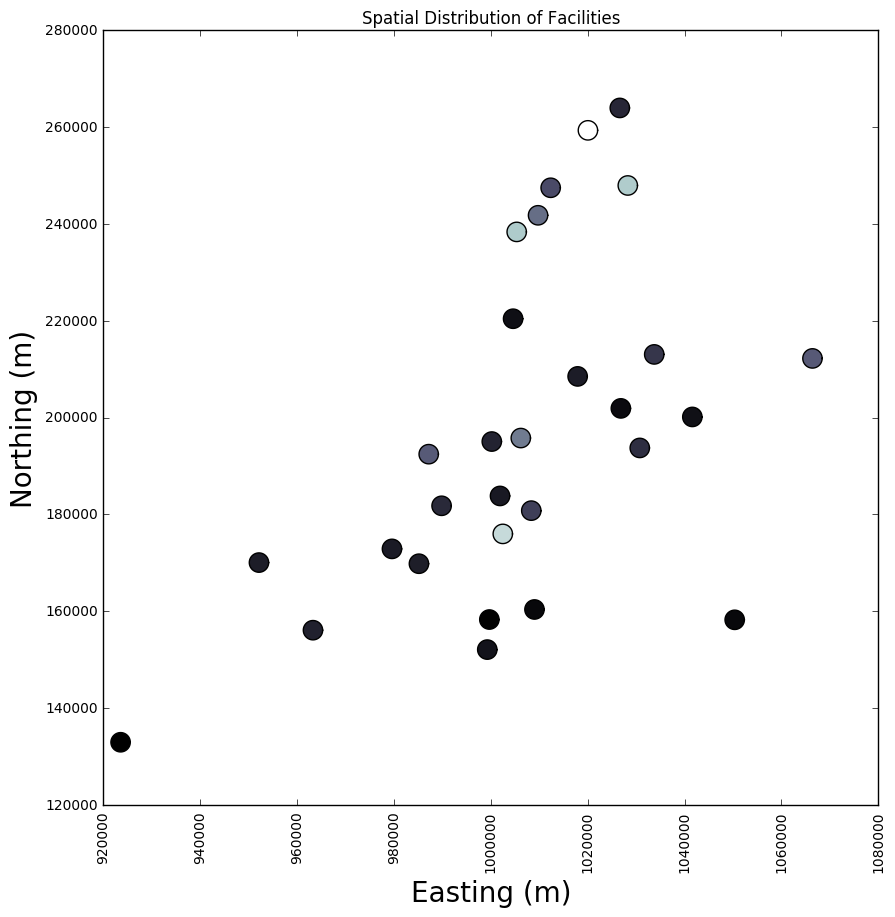

In [108]:
f, ax = plt.subplots(1, figsize=(10,10))
ax = dots.plot(column='count', colormap='bone', alpha=1, axes=ax, k=9)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Spatial Distribution of Facilities')
plt.xlabel("Easting (m)", fontsize=20)
plt.ylabel("Northing (m)", fontsize=20)
plt.show()

In [ ]:
#@Review: # missing semi variogram 
#comment on what's happening, what you infer? See solution.